status: Draft



In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa

Here are the CDFs for the kVA reports with nulls removed.

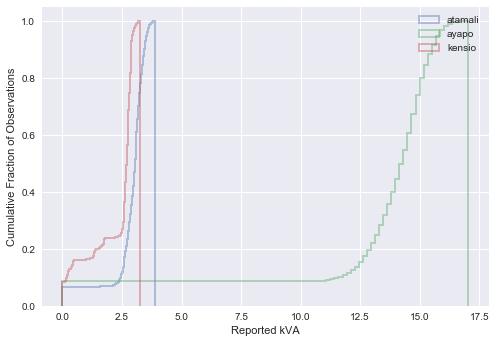

In [5]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    sns.distplot(energy_data['kVA sliding window Demand'].dropna(), 
                 hist_kws={'cumulative':True,
                           'histtype':'step',
                           'linewidth':2},
                kde=False,
                norm_hist=True,
                bins=100,
                ax=ax,
                label=vname)
ax.set_xlabel('Reported kVA')
ax.set_ylabel('Cumulative Fraction of Observations')
ax.legend()

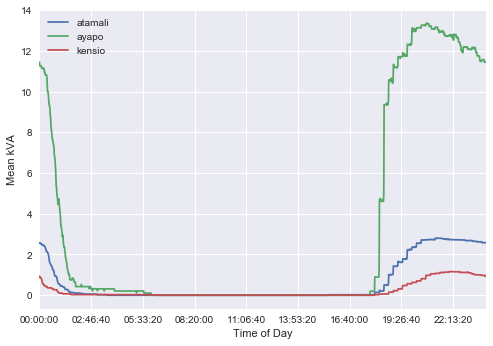

In [23]:
def wpa_averaged_power_profile(energy_data, messages):
    # create power column from current and voltage or use existing kVA fields?
    # print(energy_data.columns)
    # group by and aggregate by time
    # return series with averaged 24 hour power profile
    resampled_data = wpa.insert_zeros_kVA(energy_data, messages)
    kVA = resampled_data['kVA sliding window Demand']
    return kVA.groupby(kVA.index.time).mean()
    
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    wpa_averaged_power_profile(energy_data, messages).plot(marker='', 
                                                 linestyle='-',
                                                 label=vname)
    
ax.set_xlabel('Time of Day')
ax.set_ylabel('Mean kVA')
ax.legend()
plt.savefig('../plots/hourly_kVA.png')

In [14]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand']
    data.append({'village': vname, 
                 'mean kVA': kVA.mean(), 
                 'max kVA': kVA.max(), 
                 'kVA factor': kVA.mean()/kVA.max(), 
                 'HH': rfd['connections'], 
                 'max kVA per HH': kVA.max()/rfd['connections'],
                 'mean kVA per HH': kVA.mean()/rfd['connections']})

kVA_data = pd.DataFrame(data)

import tabulate
print(tabulate.tabulate(kVA_data, tablefmt='pipe', headers=kVA_data.columns))

|    |   HH |   kVA factor |   max kVA |   max kVA per HH |   mean kVA |   mean kVA per HH | village   |
|---:|-----:|-------------:|----------:|-----------------:|-----------:|------------------:|:----------|
|  0 |   40 |     0.73535  |     3.884 |         0.0971   |    2.8561  |         0.0714024 | atamali   |
|  1 |  103 |     0.767282 |    17.041 |         0.165447 |   13.0753  |         0.126944  | ayapo     |
|  2 |   20 |     0.690428 |     3.253 |         0.16265  |    2.24596 |         0.112298  | kensio    |


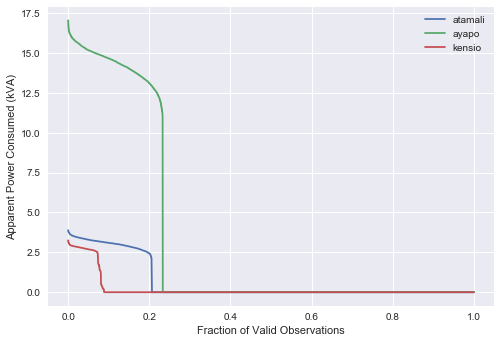

In [24]:
# load duration curve

# FIXME: we need to use a zero-filled data set
# FIXME: check that these are in WP19

def insert_power_gap_zeros(energy_data, messages):
    # this puts zeros in the recorded power gaps and leaves data gaps untouched
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    # this is diffing all columns and possibly slowing down function
    diffed = energy_data[['kWh export']].resample('1T').asfreq().diff().shift(-1)
    for i in diffed.index.values:
        # if either boundary of the interval is in a power gap, we want to insert a zero
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            diffed.loc[i]['kWh export'] = 0
        end_interval = i + np.timedelta64(1,'m')
        if np.searchsorted(power_down, end_interval) == np.searchsorted(power_up, end_interval) + 1:
            diffed.loc[i]['kWh export'] = 0
    return diffed['kWh export']

def wpa_insert_zeros_kVA(energy_data, message_data):
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values
    energy_data_rs = energy_data.resample('1T').asfreq()
    for i in energy_data_rs.index.values:
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            energy_data_rs.loc[i]['kVA sliding window Demand'] = 0
    return energy_data_rs
    
    
def wpa_load_duration_curve(energy_data):
    # sort and order from largest to smallest
    # x-axis should be percent of time but we'll do raw first
    data = energy_data['kVA sliding window Demand'].sort_values(ascending=False).dropna().values
    index = np.linspace(0, 1, len(data))
    return pd.Series(index=index, data=data)

vname = 'ajau'
vname = 'asei'
vname = 'ayapo'
vname = 'kensio'
vname = 'atamali'

fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')
    energy_data_zf = wpa_insert_zeros_kVA(energy_data, messages)
    plt.plot(wpa_load_duration_curve(energy_data_zf),
             label=vname)

ax.set_xlabel('Fraction of Valid Observations')
ax.set_ylabel('Apparent Power Consumed (kVA)')
ax.legend()
plt.savefig('../plots/load_duration_curve.png')